**Reliance Stock Price Prediction using GRU** 📈

This Notebook attempts to leverage GRU to predict stock prices of Indian giants Reliance throughout the last 5 years.

In [46]:
                             ### Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


**Indian Stocks **are suffixed with .**NS(National Stock Exchange)** or **.BO(Bombay Stock Exchange**). I will be using .NS as and added suffix to the tickers( Stock name) as they are named more intuitively(eg: **Reliance.NS**)

In [57]:
                ### Function to download data Reliance data from Yahoo Finance ###

def get_stock_data(ticker):
    # Append '.NS' for NSE or '.BO' for BSE
    symbol = f"{ticker}.NS"   # Use '.BO' for BSE
    data = yf.download(symbol, start='2020-01-01', end='2025-01-01')
    if data.empty:
        raise ValueError(f"Data for ticker {symbol} not found. Check the symbol.")
    return data['Close']

In [98]:
data = get_stock_data('RELIANCE')
print(data.tail())

[*********************100%***********************]  1 of 1 completed

Ticker      RELIANCE.NS
Date                   
2024-12-24  1222.750000
2024-12-26  1216.550049
2024-12-27  1221.050049
2024-12-30  1210.699951
2024-12-31  1215.449951


In [60]:
                           ### Function to prepare and preprocess data ###

def prepare_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []                             # Initialising empty lists
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [94]:
                                       ### Build GRU model ###

def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

Hyperparameters in the model can be changed according to requirements. For the purpose of this analysis, the selected hyperparameters yield a very accurate prediction.

In [95]:
                                        ### Model Evaluation ###


def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(
        np.concatenate((X_test[:, :, :-1].mean(axis=1), predictions), axis=1)
    )[:, -1]

    y_test = scaler.inverse_transform(
        np.concatenate((X_test[:, :, :-1].mean(axis=1), y_test.reshape(-1, 1)), axis=1)
    )[:, -1]

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"\n Model Performance:")
    print(f" MSE: {mse:.2f}")
    print(f" RMSE: {rmse:.2f}")
    print(f" MAE: {mae:.2f}")
    print(f" R² Score: {r2:.2f}")


Mean Square Error(MSE), Mean Absolute Error(MAE), and R-Sqaured statistics are used as evaluation metrics.

In [96]:
                                       #### Train GRU Model ####

def train_and_predict(ticker):
    data = get_stock_data(ticker)
    X, y, scaler = prepare_data(data)

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]


   # Build and train GRU model
         ### Epoch is selected as 20 to reduce time complexity and fit the hardware requirements

    gru_model = build_gru_model(X_train.shape[1:])
    gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
                  callbacks=[EarlyStopping(patience=5), ReduceLROnPlateau(patience=3)])

    # Evaluating models

    print("\n GRU Model Performance:")
    evaluate_model(gru_model, X_test, y_test, scaler)

    pred_gru = gru_model.predict(X_test)
    final_pred= pred_gru



    # Rescale and plot results

    final_pred = scaler.inverse_transform(
        np.concatenate((X_test[:, :, :-1].mean(axis=1), final_pred), axis=1)
    )[:, -1]

    y_test = scaler.inverse_transform(
        np.concatenate((X_test[:, :, :-1].mean(axis=1), y_test.reshape(-1, 1)), axis=1)
    )[:, -1]


    plt.figure(figsize=(14, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(final_pred, label='Predicted', linestyle='--')
    plt.legend()
    plt.show()


[*********************100%***********************]  1 of 1 completed


 Training Bidirectional LSTM + GRU ensemble for RELIANCE...
Epoch 1/20



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - loss: 0.1165 - val_loss: 0.0159 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0089 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.0055 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0041 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0037 - val_loss: 9.4468e-04 - learning_rate: 0.0010
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0035 - val_loss: 9.1432e-04 - learning_rate: 0.0010
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0035 - val_loss: 4.5006e-04 - learning_rate: 0.0010
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0037 - val_loss: 3.9076e-04 - learning_rate: 0.0010
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0035 - val_loss: 6.0334e-04 - learning_rate: 0.0010
Epoch

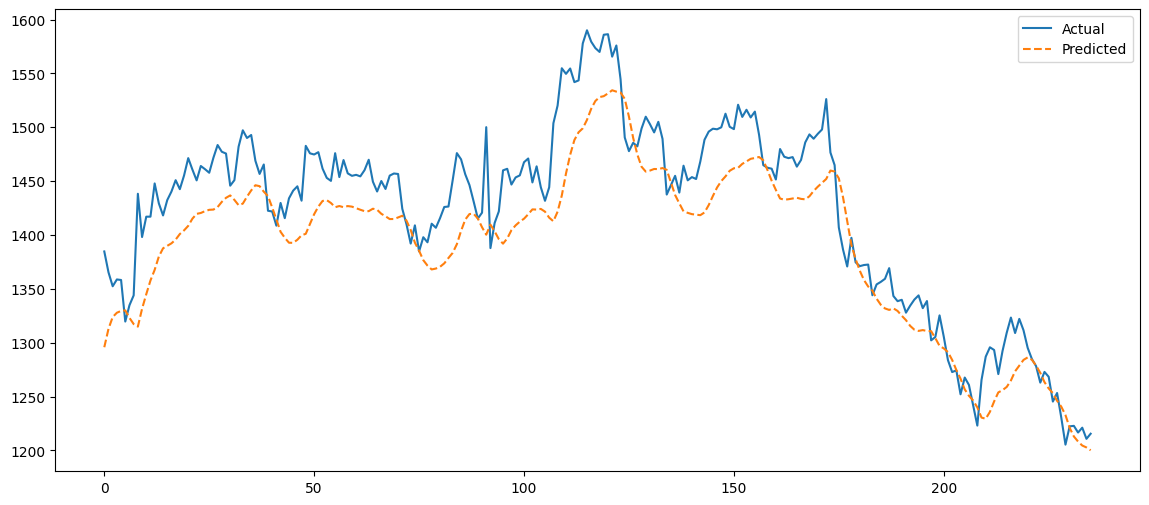

In [97]:
                                       ####### Main function ######

def main():
    ticker = 'RELIANCE'
    print(f"\n Training Bidirectional LSTM + GRU ensemble for {ticker}...")
    try:
        train_and_predict(ticker)
    except Exception as e:
        print(f" Error: {e}")

if __name__ == "__main__":
    main()



1.   The GRU model seem to perform exceptionally well to capture the rends in Reliance stock data over the the past 5 years. The plot shows the predicted line(orange) runs very close to the actual line(blue), capturing the upwards and downwards trends with a fair bit of accuracy.
2.   The evaluation metrics are very positive with a R-Squared satistic very close to one, which indicates that the our model is very high-performing.



Future Improvements:

- Pairing with LSTM or Birectional LSTM with Attention to build an ensemble model.
- Add future price prediction using rolling window mechanism.
- Add more features that might affect stock prices.
- Add sentiment analysis based on news data.  
- Experiment with Transformer-based models.  
- Enhance feature engineering using additional market data.  



